### Hi


In [1]:
from sklearn.svm import SVC
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

import numpy as np
import matplotlib.pyplot as plt

Here we assign our various data points. They are well separated (an easy case). Note, we are also defining an arbitrary w and b.

In [2]:

#Data Set
x_neg = np.array([[3, 4], [1, 4], [2, 3]]) # features
y_neg = np.array([-1, -1, -1]) # labels of x_neg

x_pos = np.array([[6, -1], [7, -1], [5, -3]]) # features
y_pos = np.array([1, 1, 1]) # label of x_pos

x1 = np.linspace(-10, 10)
x = np.vstack((np.linspace(-10, 10), np.linspace(-10, 10))) #

X = np.vstack((x_pos, x_neg)) # Complete features
y = np.concatenate((y_pos, y_neg)) # Complete label for each feature

w = np.array([1.5, -0.5]).reshape(-1, 1)
b = [-3]

Now let's have a look at our data visually. We've done a little bit of algebra to 'recreate' our line.

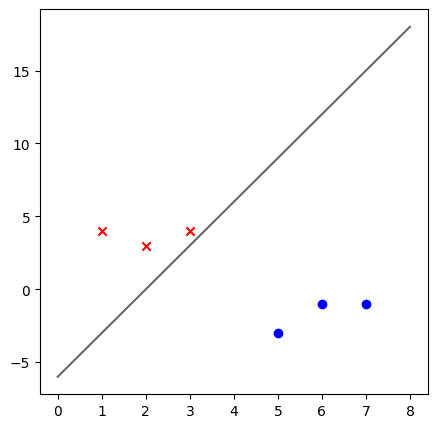

In [3]:

x1 = np.linspace(-0, 8)
fig = plt.figure(figsize = (5, 5))

plt.scatter(x_neg[:, 0], x_neg[:, 1], marker = 'x', color = 'r', label = 'Negative (-1)')
plt.scatter(x_pos[:, 0], x_pos[:, 1], marker = 'o', color = 'b', label = 'Positive (+1)')
# f(x1)=(-wx1-b)/w
plt.plot(x1, ((-w[0] * x1 - b[0])/w[1]).flatten(), color = 'k', alpha = 0.6, label = 'old boundary')

[Standard quadratic programming](https://optimization.cbe.cornell.edu/index.php?title=Quadratic_programming):

Primal Form

$\begin{equation} \min q(x) = c^Tx+\underbrace{\frac{1}{2}x^TQx}_{quadratic form} \end{equation}$

$\begin{equation} s.t.\quad Ax \geq b \end{equation}$

$\begin{equation} x\geq 0 \end{equation}$

Where:

- $x\in \mathbf{R}^{n}$ is the decision variable vector.
- $Q\in \mathbf{R}^{n\times n}$ is a symmetric, positive semi-definite $n\times n$ matrix representing the quadratic coefficients.
- $A\in \mathbf{R}^{m\times n}$ is the *inequality constraint* matrix.
- $b\in \mathbf{R}^{m}$ is a $n\times n$ dimensional vector representing a constraint boundary.
- $c\in \mathbf{R}^{n}$ is a linear coefficient vector.

Dual form

$\begin{equation} \max q(x, y) = b^Ty - \frac{1}{2}x^TQx \end{equation}$

$\begin{equation} s.t.\quad A^Ty - Qx + s = c \end{equation}$

$\begin{equation} y, s \geq 0 \end{equation}$

where:

- $y\in \mathbf{R}^{m}$ is an m-dimensional vector dual variable.
- $x\in \mathbf{R}^{n}$ is the prime decision variable.
- $s\in \mathbf{R}^{n}$ is the slack variable.
- $Q\in \mathbf{R}^{n\times n}$ is a symmetric, positive semi-definite $n\times n$ matrix representing the quadratic coefficients.
- $A\in \mathbf{R}^{m\times n}$ is the inequality constraint matrix.
- $b\in \mathbf{R}^{m}$ is an $m$ dimensional vector representing a constraint boundary.
- $c\in \mathbf{R}^{n}$ is a linear coefficient for the dual target.


another quadratic program format
<!-- $\begin{equation}\min f(x) = q^Tx + \frac{1}{2}x^TQx \end{equation}$

$\begin{equation}s.t.\quad Ax=a \end{equation}$

$\begin{equation}Bx\leq b \end{equation}$

$\begin{equation}x\geq 0 \end{equation}$ -->

$w = \sum_i\alpha_iy_ix_i \sim(Y\alpha)^TX$

$b^* = y_i - w^*x$ which conducted by KKT condition

following standard equation are given by cvxpy (not cvxopt) quadratic programming example
$$
\begin{equation*}
  \begin{aligned}
    \text{minimize}\quad &\frac{1}{2}x^TPx+q^Tx \\
    \text{subject to}\quad &Gx\leq h \\
    &Ax = b
  \end{aligned}
\end{equation*}
$$

In [ ]:
# Initialising values and computing H
m, n = X.shape
y = y.reshape(-1, 1) * 1.0
X_dash = y * X
H = np.dot(X_dash, X_dash.T) * 1.0

# CVXOPT formatting
P = cvxopt_matrix(H)                    # yX(yX)'
q = cvxopt_matrix(-np.ones((m, 1)))     # Lots of -1
G = cvxopt_matrix(-np.eye(m))           # Identity matrix
h = cvxopt_matrix(np.zeros(m))          # Lots of zeros
A = cvxopt_matrix(y.reshape(1, -1))     # y with different dimensions
b = cvxopt_matrix(np.zeros(1))          # more zeros

# Setting solver parameters
cvxopt_solvers.options['show_progress'] = False
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

# Solve our problem
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

# Calculate our w (from lectures SUM(ai * yi * xi))
w = ((y * alphas).T @ X).reshape(-1, 1)

# Finding the non-zero alphas
S = (alphas > 1e-4).flatten() # support vectors

# B is y - x.W
b = y[S] - np.dot(X[S], w)
print("Alphas = ", alphas[alphas > 1e-4])
print("w:", w.T, ", b:", b.T)


Alphas =  [0.0625     0.06249356]
w: [[ 0.24999356 -0.25000644]] , b: [[-0.74996781 -0.74996781]]


<img src="./img/support-vector.png" alt="James et al. 2023, p. 371" width="400" height="300" />


All samples $x_i$ ​ for which the corresponding parameter $\alpha_i=0$ can be referred to as "support vectors," as they mathematically "support" the position of the separating hyperplane (Deisenroth, Faisal & Ong 2020, p. 384).

"Support vectors are the data points that lie closest to the decision surface (or hyperplane)" (MIT 2011)<https://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf>

Let's draw it a second time, this time with a real 'w' and 'b'.

Text(0, 0.5, '$x_2$')

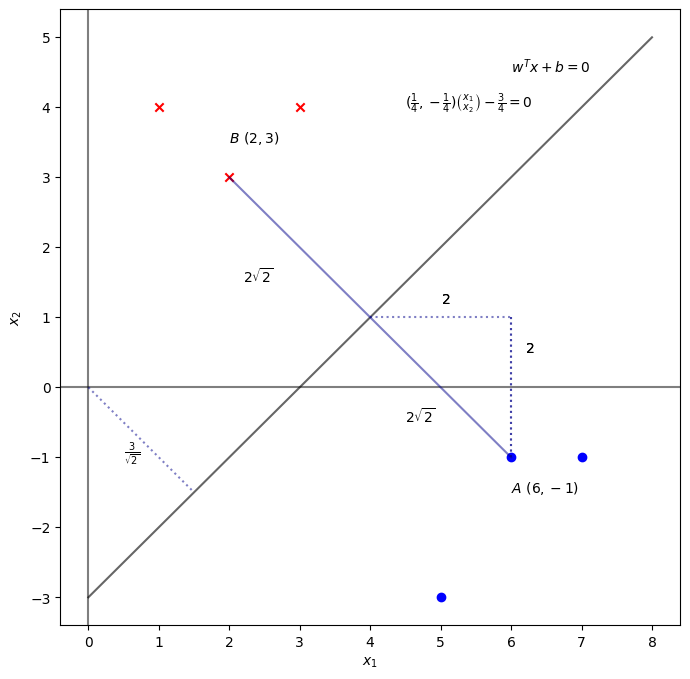

In [5]:
x1 = np.linspace(-0, 8)
fig = plt.figure(figsize = (8, 8))
plt.scatter(x_neg[:, 0], x_neg[:, 1], marker = 'x', color = 'r', label = 'Negative (-1)')
plt.scatter(x_pos[:, 0], x_pos[:, 1], marker = 'o', color = 'b', label = 'Positive (+1)')
plt.plot(x1, ((-w[0] * x1 - b[0])/w[1]).flatten(), color='k', alpha = 0.6, label = 'new boundary')


#Lines
plt.axvline(0, color = 'black', alpha = 0.5)
plt.axhline(0, color = 'black', alpha = 0.5)
plt.plot([2, 6], [3, -1], linestyle = '-', color = 'darkblue', alpha = 0.5)
plt.plot([4, 6], [1, 1], [x_pos[0, 0], x_pos[0, 0]], [1, -1], linestyle= ":", color = 'darkblue', alpha = 0.5)
plt.plot([0, 1.5], [0, -1.5], [x_pos[0, 0], x_pos[0, 0]], [1, -1], linestyle= ":", color = 'darkblue', alpha = 0.5)

plt.annotate(text = '$A \ (6, -1$)', xy = (5, -1), xytext = (6, -1.5))
plt.annotate(text = '$B \ (2, 3$)', xy = (2, 3), xytext = (2, 3.5))
plt.annotate(text = '$2$', xy = (5, 1.2), xytext = (5, 1.2))
plt.annotate(text = '$2$', xy = (6.2, 0.5), xytext = (6.2, 0.5))

plt.annotate(text = '$2\sqrt{2}$', xy = (4.5, -0.5), xytext = (4.5, -0.5))
plt.annotate(text = '$2\sqrt{2}$', xy = (2.2, 1.5), xytext = (2.2, 1.5))

plt.annotate(text = '$2$', xy = (5, 1.2), xytext = (5, 1.2))
plt.annotate(text = '$2$', xy = (6.2, 0.5), xytext = (6.2, 0.5))

plt.annotate(text = '$w^Tx + b = 0$', xy = (6, 4.5), xytext = (6, 4.5))
plt.annotate(text = '$(\\frac{1}{4}, -\\frac{1}{4}) \\binom{x_1}{x_2}- \\frac{3}{4} = 0$', xy = (4.5, 4), xytext = (4.5, 4))

plt.annotate(text = '$\\frac{3}{\sqrt{2}}$', xy = (0.5, -1), xytext = (0.5, -1))

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

### Reference

[[1]]((https://link.springer.com/book/10.1007/978-3-031-38747-0)) James, G 2023, *An Introduction to Statistical Learning : with Applications in Python*, 1st ed. 2023., Springer International Publishing, Cham.

[2]Deisenroth, M. P., Faisal, A., & Ong, C. S. (2020), *Mathematics for Machine Learning*, Cambridge University Press.